In [3]:
import os
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scipy.fft import fft2, fftshift
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def extract_and_resize_images(zip_path, extract_path, target_size=(256, 256)):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    real_folder = os.path.join(extract_path, 'REAL')
    fake_folder = os.path.join(extract_path, 'FAKE')

    resize_images(real_folder, target_size)
    resize_images(fake_folder, target_size)

    print("Image extraction and resizing completed.")

def resize_images(folder, target_size):
    for filename in os.listdir(folder):
        if filename.endswith('.jpg'):
            image_path = os.path.join(folder, filename)
            output_path = os.path.join(folder, filename)
            with Image.open(image_path) as img:
                img = img.resize(target_size)
                img.save(output_path)

def extract_fft_features(image):
    f_transform = fft2(image)
    f_shifted = fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shifted + 1e-8)
    return magnitude_spectrum

def get_mean_freq_2d(magnitude_spectrum):
    return np.mean(magnitude_spectrum)

def get_std_freq_2d(magnitude_spectrum):
    return np.std(magnitude_spectrum)

def get_skewness_freq_2d(magnitude_spectrum):
    return skew(magnitude_spectrum.flatten())

def get_kurtosis_freq_2d(magnitude_spectrum):
    return kurtosis(magnitude_spectrum.flatten())

def get_energy_freq_2d(magnitude_spectrum):
    return np.sum(magnitude_spectrum**2)

def get_entropy_freq_2d(magnitude_spectrum):
    normalized_spectrum = magnitude_spectrum / np.sum(magnitude_spectrum)
    return -np.sum(normalized_spectrum * np.log(normalized_spectrum + 1e-8))

def extract_features_and_create_dataframe(real_folder, fake_folder):
    data = []
    columns = ['Mean', 'Std', 'Skewness', 'Kurtosis', 'Energy', 'Entropy', 'Label']

    def process_folder(folder, label):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            with Image.open(file_path) as img:
                image = np.array(img.convert('L'))
            magnitude_spectrum = extract_fft_features(image)

            mean = get_mean_freq_2d(magnitude_spectrum)
            std = get_std_freq_2d(magnitude_spectrum)
            skewness = get_skewness_freq_2d(magnitude_spectrum)
            kurtosis_val = get_kurtosis_freq_2d(magnitude_spectrum)
            energy = get_energy_freq_2d(magnitude_spectrum)
            entropy = get_entropy_freq_2d(magnitude_spectrum)

            data.append([mean, std, skewness, kurtosis_val, energy, entropy, label])

    process_folder(real_folder, 1)
    process_folder(fake_folder, 0)

    df = pd.DataFrame(data, columns=columns)
    return df

zip_path = '/content/Detect_AI_Art.zip'
extract_path = '/content/'

#extract_and_resize_images(zip_path, extract_path)

real_folder = '/content/REAL'
fake_folder = '/content/FAKE'
feature_df = extract_features_and_create_dataframe(real_folder, fake_folder)

feature_df.to_csv('image_fft_features.csv', index=False)
print(feature_df.head())

          Mean           Std    Skewness      Kurtosis        Energy  \
0  4242.288864  20913.826842  179.098974  39939.887962  2.984412e+13   
1  3602.145788  21210.520426  141.951932  27738.050043  3.033410e+13   
2  3203.454056  35349.108449  231.483466  57140.654659  8.256367e+13   
3  3309.978391  30846.938406  198.414701  46103.019610  6.307772e+13   
4  3282.648214  28997.173461  162.493195  34086.970220  5.581123e+13   

     Entropy  Label  
0  10.293264      1  
1  10.061722      1  
2   9.927005      1  
3   9.788680      1  
4   9.662617      1  


In [8]:
feature_df = pd.read_csv('image_fft_features.csv')
print(feature_df.head())

       Mean       Std  Skewness  Kurtosis        Energy    Entropy  Label
0  8.571300  0.988061  0.159426  1.215908  1.951490e+07  12.467364      1
1  8.400005  1.030195  0.328297  1.291149  1.877511e+07  12.466533      1
2  7.597910  1.057859  0.219371  0.945817  1.542647e+07        NaN      1
3  8.069598  1.027617  0.347758  1.276599  1.734723e+07  12.465950      1
4  7.391994  1.037208  0.149188  0.883219  1.460597e+07  12.464127      1


Epoch 1/50
246/246 [==============================] - 1s 2ms/step - loss: 233614.9375 - accuracy: 0.5051 - val_loss: 1647.3112 - val_accuracy: 0.5055
Epoch 2/50
246/246 [==============================] - 0s 1ms/step - loss: 34065.4141 - accuracy: 0.5002 - val_loss: 270.6956 - val_accuracy: 0.5055
Epoch 3/50
246/246 [==============================] - 0s 1ms/step - loss: 10829.9053 - accuracy: 0.5014 - val_loss: 103.7318 - val_accuracy: 0.5055
Epoch 4/50
246/246 [==============================] - 0s 2ms/step - loss: 5260.9468 - accuracy: 0.4908 - val_loss: 38.5665 - val_accuracy: 0.4945
Epoch 5/50
246/246 [==============================] - 1s 2ms/step - loss: 4031.8311 - accuracy: 0.4762 - val_loss: 4.4750 - val_accuracy: 0.4945
Epoch 6/50
246/246 [==============================] - 1s 3ms/step - loss: 1070.3726 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 7/50
246/246 [==============================] - 1s 2ms/step - loss: 1051.6980 - accuracy: 0.4831 - val_loss: 0.6

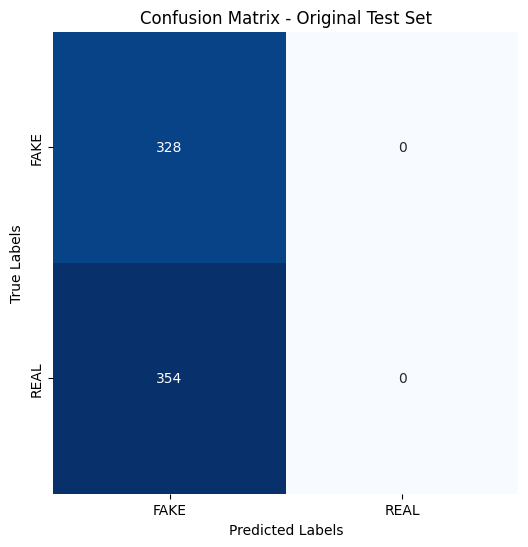

In [9]:
X = feature_df.drop('Label', axis=1)
y = feature_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

X_train = imputer.fit_transform(X_train)

X_test = imputer.transform(X_test)

model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.1, verbose=1)

y_pred = model.predict(X_test).round()
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of the model: {accuracy}')

original_test_predictions = model.predict(X_test)
original_test_predictions_classes = (original_test_predictions > 0.5).astype(int)

original_test_cm = confusion_matrix(y_test, original_test_predictions_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(original_test_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Original Test Set')
plt.show()

In [ ]:
epsilon = 0.01
adversarial_test_images = []

for i in range(len(X_test)):
    gradients = np.random.randn(*X_test[i].shape)
    scaled_gradients = epsilon * np.sign(gradients)
    adversarial_image = X_test[i] + scaled_gradients
    adversarial_image = np.clip(adversarial_image, 0, 1)
    adversarial_test_images.append(adversarial_image)

adversarial_test_images = np.array(adversarial_test_images)

X_test_adversarial_fft = np.array([extract_fft_features(image.squeeze()) for image in adversarial_test_images])

adversarial_test_predictions = model.predict(X_test_adversarial_fft).round()

adversarial_test_cm = confusion_matrix(y_test, adversarial_test_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(adversarial_test_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Adversarial Test Set')
plt.show()

ValueError: axes exceeds dimensionality of input

In [ ]:
def plot_original_and_fft(original_image, fft_image):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(fft_image, cmap='gray')
    axes[1].set_title('Magnitude Spectrum')
    axes[1].axis('off')

    plt.show()

def plot_images_and_ffts(original_images, adversarial_images, num_samples=5):
    for i in range(num_samples):
        original_image = original_images[i].squeeze()
        adversarial_image = adversarial_images[i].squeeze()

        original_fft = np.log(np.abs(fftshift(fft2(original_image))) + 1e-8)
        adversarial_fft = np.log(np.abs(fftshift(fft2(adversarial_image))) + 1e-8)

        plot_original_and_fft(original_image, original_fft)
        plot_original_and_fft(adversarial_image, adversarial_fft)

num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
original_sample_images = X_test.values[random_indices]
adversarial_sample_images = adversarial_test_images[random_indices]

plot_images_and_ffts(original_sample_images, adversarial_sample_images, num_samples)